In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)

for device in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

import sys
sys.version


C:\Users\Chanv\anaconda3\envs\tf2\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Num GPUs Available:  1
True
2.10.1


'3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:28:38) [MSC v.1929 64 bit (AMD64)]'

In [2]:
DATASET_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train'
BATCH_SIZE = 16
EPOCHS = 3
TEACHER1_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/lstm_model2.hdf5"
TEACHER2_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/simpleAutoencoder2.hdf5"
STUDENT1_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_model1.hdf5"
STUDENT2_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd1.hdf5"
STUDENT3_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd2.h5"
STUDENT4_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd3.h5"
STUDENT5_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd4.h5"
STUDENT6_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd5.h5"
STUDENT7_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd6.h5"
STUDENT8_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd7.h5"
STUDENT9_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd8.h5"


test_path1 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test001'
test_path2 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test003'
test_path3 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test013'
test_path4 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test006'
test_path5 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test032'


MEAN_MSE_VALUES_OBJECT_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/mean_mse.pkl"
MODEL_METRICS_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/model_metrics.pkl"
MODEL_METRICS_TABULATED_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/model_metrics_tabulated_ped1.csv"

# student1 = no kd
# student2 = kd with teacher 1, student alpha as 0.5, with teacher1 alpha as 0.5
# student3 = kd with teacher 1 and 2, student alpha as 0.5, with teacher1 alpha as 0.5, teacher2 alpha as 0.2
# student4 = kd with teacher 1 and 2, student alpha as 0.4, with teacher1 alpha as 0.4, teacher2 alpha as 0.2
# student5 = kd with teacher 1 and 2, student alpha as 1, with teacher1 alpha as 0.7, teacher2 alpha as 0.3
# student6 = kd with teacher 1 and 2, student alpha as 0.4, with teacher1 alpha as 0.5, teacher2 alpha as 0.1
# student7 = kd with teacher 1 and 2, student alpha as 0.5, with teacher1 alpha as 0.5, teacher2 alpha as 0, avg of both teacher
# student8 = kd with dynamic weight allocation to both teacher distillation loss and student reconstruction loss
# student9 = kd with teacher 2, student alpha as 0.5, with teacher2 alpha as 0.5

In [3]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt

In [4]:
def plot_regularity(size, sequences, reconstructed_sequences):
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,size)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost) - np.min(sequences_reconstruction_cost))
    sr = 1.0 - sa
    # ( mse - min_mse ) / max_mse - min_mse
    # plot the regularity scores
    sequence_numbers = [i for i in range(1, len(sequences) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    plt.plot(sequence_numbers, sr)
    plt.ylabel('Regularity score')
    plt.xlabel('Sequence Number')
    plt.show()

    return sr

In [5]:
def get_mse(sequences, reconstructed_sequences):
    mse = np.mean(np.square(sequences - reconstructed_sequences), axis=(1,2,3))
    return mse

In [6]:
def plot_mse_change(mse_values, mean_mse=0, legend = None, doPlotThreshold = False):


    # Plot MSE against frame number
    sequence_numbers = [i for i in range(1, len(mse_values) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    
    plt.plot(sequence_numbers, mse_values, color='g', marker='o', linestyle='-')
    plt.xlabel('Sequence Number')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE Against Sequence Number')
    plt.grid(True)

    if doPlotThreshold:
        plt.axhline(y=mean_mse, color='c', linestyle='--', label='Mean MSE')
        plt.legend(legend)
    plt.show()

In [7]:
import cv2
import os
import numpy as np

def preprocess_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []


    # Loop through each video sequence in the dataset
    for sequence_folder in os.listdir(data_path):
        sequence_path = os.path.join(data_path, sequence_folder)
        if sequence_path.endswith("Store"):
            continue
        print(sequence_path)

        frames = []
        # Read frames from the video sequence
        for frame_file in sorted(os.listdir(sequence_path)):
            if frame_file.endswith("Store"):
                continue

            if len(frames) == 10:
                preprocessed_data.append(frames)
                frames = []

            frame_path = os.path.join(sequence_path, frame_file)
            frame = cv2.imread(frame_path)
            frame = cv2.resize(frame, output_shape)  # Resize frame
            # frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # frame_gray = frame_gray[:, :, np.newaxis]
            frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
            # frame_ray = frame_gray.astype(np.float32) / 255.0
            frames.append(frame)
        preprocessed_data.append(frames)

    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)

    return preprocessed_data


# Path to the Ped2 dataset
data_path = DATASET_PATH

# Preprocess the Ped2 dataset
preprocessed_data = preprocess_dataset(data_path)
preprocessed_data = preprocessed_data[:150]

# Check the shape of the preprocessed data
print("Preprocessed dataset shape:", preprocessed_data.shape)


C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train001
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train002
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train003
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train004
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train005
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train006
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train007
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train008
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train009
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train010
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train011
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train012
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train013
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train014
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train015
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train016
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSD

In [8]:
from sklearn.model_selection import train_test_split

# Build autoencoder model
train_data, val_data = train_test_split(preprocessed_data, test_size=0.2, random_state=42)

# Teacher models

## Teacher 1

In [9]:
from keras.models import load_model
teacher1 = load_model(TEACHER1_PATH)
teacher1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 32, 32, 64)   23296     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 32, 32, 64)   128       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 16, 16, 32)   51232     
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 16, 16, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 16, 16, 64)    2

## Teacher 2

In [10]:
from keras.models import load_model
teacher2 = load_model(TEACHER2_PATH)
teacher2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 128, 128, 128  10496     
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 64, 64, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 64, 64, 64)    221248    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 32, 32, 64)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 32, 32, 64)    110656    
                                                        

# Student

In [11]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model

def get_student_model():
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(32, (5, 5), strides=2, padding="same"), batch_input_shape=(None, 10, 128, 128, 3)))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(32, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    return seq


### Without KD

In [12]:
# Create the student model
student_model1 = get_student_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 64, 64, 32)   2432      
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 64, 64, 32)   64        
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_1 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 128, 128, 32)  25632    
 tributed)                                              

In [13]:
# Train autoencoder
student_model1.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-6))
# student_model1.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=BATCH_SIZE)
# student_model1.student.save(STUDENT1_PATH)
student_model1 = load_model(STUDENT1_PATH)


### With KD

In [14]:
def compute_correlation(x, y):
    x_mean = tf.reduce_mean(x, axis=(1, 2, 3), keepdims=True)
    y_mean = tf.reduce_mean(y, axis=(1, 2, 3), keepdims=True)
    x_centered = x - x_mean
    y_centered = y - y_mean

    numerator = tf.reduce_sum(x_centered * y_centered, axis=(1, 2, 3))
    denominator = tf.sqrt(tf.reduce_sum(tf.square(x_centered), axis=(1, 2, 3))) * tf.sqrt(tf.reduce_sum(tf.square(y_centered), axis=(1, 2, 3)))
    correlation = numerator / (denominator + tf.keras.backend.epsilon())
    return correlation

In [15]:

class AutoencoderDistiller(keras.Model):
    def __init__(self, student, teacher1, teacher2=None):
        super(AutoencoderDistiller, self).__init__()
        self.teacher1 = teacher1
        self.teacher2 = teacher2
        self.student = student


    def compile(self, optimizer, metrics, reconstruction_loss_fn, distillation_loss_fn, alpha, sAlpha=0.5, beta=0, method='Normal'):
        super(AutoencoderDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.reconstruction_loss_fn = reconstruction_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.sAlpha = sAlpha
        self.alpha = alpha
        self.beta = beta
        self.method = method

    def train_step(self, data):
        x, _ = data  # Unpack input data (no labels)

        with tf.GradientTape() as tape:
            # Forward pass of student
            reconstructed_x = self.student(x, training=True)
            # Compute reconstruction loss
            reconstruction_loss = self.reconstruction_loss_fn(x, reconstructed_x)

            # Forward pass of teacher
            teacher1_reconstructed_x = self.teacher1(x, training=False)

            # Compute distillation loss
            distillation_loss1 = self.distillation_loss_fn(reconstructed_x, teacher1_reconstructed_x)



            loss = 0
            # Total loss
            if(self.method == 'Normal'):
                loss = self.sAlpha * reconstruction_loss + self.alpha * distillation_loss1

            if self.teacher2 is not None:
                 # Forward pass of teacher
                teacher2_reconstructed_x = self.teacher2(x, training=False)
                # Compute distillation loss
                distillation_loss2 = self.distillation_loss_fn(reconstructed_x, teacher2_reconstructed_x)



                if(self.method == 'Normal'):
                    loss += self.beta * distillation_loss2
                elif(self.method == 'Average'):
                    loss = self.sAlpha * reconstruction_loss + self.alpha * ((distillation_loss1 + distillation_loss2) / 2)
                elif(self.method == 'Dynamic'):
                   
                    reconstruction_correlation = (compute_correlation(tf.reduce_mean(x, axis=-1, keepdims=True), reconstructed_x) + 1) / 2
                    distillation1_correlation = (compute_correlation(reconstructed_x, teacher1_reconstructed_x) + 1) / 2
                    distillation2_correlation = (compute_correlation(reconstructed_x, tf.reduce_mean(teacher2_reconstructed_x, axis=-1, keepdims=True)) + 1) / 2

                   
                    total_weight = reconstruction_correlation + distillation1_correlation + distillation2_correlation
                    reconstruction_weight = reconstruction_correlation / total_weight
                    distillation1_weight = distillation1_correlation / total_weight
                    distillation2_weight = distillation2_correlation / total_weight

                    self.sAlpha = reconstruction_weight
                    self.alpha = distillation1_weight
                    self.beta = distillation2_weight

                    loss = self.sAlpha * reconstruction_loss + self.alpha * distillation_loss1 + self.beta * distillation_loss2

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics
        self.compiled_metrics.update_state(x, reconstructed_x)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        if self.teacher2 is not None:
            results.update({"reconstruction_loss": reconstruction_loss, "distillation_loss_t1": distillation_loss1, "distillation_loss_t2": distillation_loss2, 'r_weight': reconstruction_weight, 'd1_weight': distillation1_weight, 'd2_weight': distillation2_weight})
        else:
            results.update({"reconstruction_loss": reconstruction_loss, "distillation_loss_t1": distillation_loss1})
        return results

    def test_step(self, data):
        x, _ = data  # Unpack input data (no labels)

        # Forward pass of student
        reconstructed_x = self.student(x, training=False)

        # Compute reconstruction loss
        reconstruction_loss = self.reconstruction_loss_fn(x, reconstructed_x)

        # Update the metrics
        self.compiled_metrics.update_state(x, reconstructed_x)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"reconstruction_loss": reconstruction_loss})
        return results

    def predict(self, data):
        # Perform forward pass inference using the student model
        return self.student(data, training=False)




### Single teacher 1

In [16]:
student_model_kd1 = get_student_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 64, 64, 32)   2432      
 tributed)                                                       
                                                                 
 layer_normalization_3 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_4 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 128, 128, 32)  25632    
 tributed)                                            

In [17]:
from tensorflow.keras.optimizers import Adam

student_model_kd1 = AutoencoderDistiller(student=student_model_kd1, teacher1=teacher1, teacher2 = None)
student_model_kd1.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0.2
)


In [18]:
# Train autoencoder
# student_model_kd1.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)
# student_model_kd1.student.save_weights(STUDENT2_PATH)

student_model_kd1.built = True
student_model_kd1.student.load_weights(STUDENT2_PATH)
student_model_kd1.summary()

Model: "autoencoder_distiller"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 128, 128, 1)   935681    
                                                                 
 sequential_1 (Sequential)   (None, 10, 128, 128, 1)   105985    
                                                                 
Total params: 1,041,666
Trainable params: 1,041,666
Non-trainable params: 0
_________________________________________________________________


### Single teacher 2

In [19]:
student_model_kd8 = get_student_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 64, 64, 32)   2432      
 tributed)                                                       
                                                                 
 layer_normalization_6 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_7 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 128, 128, 32)  25632    
 tributed)                                            

In [20]:
from tensorflow.keras.optimizers import Adam

student_model_kd8 = AutoencoderDistiller(student=student_model_kd8, teacher1=teacher2, teacher2 = None)
student_model_kd8.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0.2
)


In [21]:
# Train autoencoder
# student_model_kd8.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)
# student_model_kd8.student.save_weights(STUDENT9_PATH)

student_model_kd8.built = True
student_model_kd8.student.load_weights(STUDENT9_PATH)
student_model_kd8.summary()

Model: "autoencoder_distiller_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 128, 128, 3)   574083    
                                                                 
 sequential_2 (Sequential)   (None, 10, 128, 128, 1)   105985    
                                                                 
Total params: 680,068
Trainable params: 680,068
Non-trainable params: 0
_________________________________________________________________


### Two teachers 1

In [22]:
student_model_kd2 = get_student_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 10, 64, 64, 32)   2432      
 tributed)                                                       
                                                                 
 layer_normalization_9 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_10 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_10 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [23]:
from tensorflow.keras.optimizers import Adam

student_model_kd2 = AutoencoderDistiller(student=student_model_kd2, teacher1=teacher1, teacher2 = teacher2)
student_model_kd2.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0.2
)

In [24]:
# # Train autoencoder
# student_model_kd2.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd2.student.save_weights(STUDENT3_PATH)

In [25]:
student_model_kd2.built = True
student_model_kd2.student.load_weights(STUDENT3_PATH)

In [26]:
student_model_kd2.evaluate(val_data, val_data)

1/1 [==============================] - 6s 6s/step - mean_squared_error: 0.0050 - reconstruction_loss: 0.0050


[0.004995504394173622, 0.004995504394173622]

### Two teachers 2

In [27]:
student_model_kd3 = get_student_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_12 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_13 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [28]:
from tensorflow.keras.optimizers import Adam

student_model_kd3 = AutoencoderDistiller(student=student_model_kd3, teacher1=teacher1, teacher2 = teacher2)
student_model_kd3.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.4,
    sAlpha=0.4,
    beta=0.2
)

In [29]:
# # Train autoencoder
# student_model_kd3.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd3.student.save_weights(STUDENT4_PATH)

In [30]:
student_model_kd3.built = True
student_model_kd3.student.load_weights(STUDENT4_PATH)

In [31]:
student_model_kd3.evaluate(val_data, val_data)

1/1 [==============================] - 1s 968ms/step - mean_squared_error: 0.0047 - reconstruction_loss: 0.0047


[0.004719519522041082, 0.004719519522041082]

### Two teachers 3

In [32]:
student_model_kd4 = get_student_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_15 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_16 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [33]:
from tensorflow.keras.optimizers import Adam

student_model_kd4 = AutoencoderDistiller(student=student_model_kd4, teacher1=teacher1, teacher2 = teacher2)
student_model_kd4.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.7,
    sAlpha=1,
    beta=0.3
)

In [34]:
# # Train autoencoder
# student_model_kd4.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd4.student.save_weights(STUDENT5_PATH)

In [35]:
student_model_kd4.built = True
student_model_kd4.student.load_weights(STUDENT5_PATH)

In [36]:
student_model_kd4.evaluate(val_data, val_data)

1/1 [==============================] - 1s 988ms/step - mean_squared_error: 0.0044 - reconstruction_loss: 0.0044


[0.004431975074112415, 0.004431975074112415]

### Two teachers 4

In [37]:
student_model_kd5 = get_student_model()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_18 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_19 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_19 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [38]:
from tensorflow.keras.optimizers import Adam

student_model_kd5 = AutoencoderDistiller(student=student_model_kd5, teacher1=teacher1, teacher2 = teacher2)
student_model_kd5.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.4,
    beta=0.1
)

In [39]:
# # Train autoencoder
# student_model_kd5.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd5.student.save_weights(STUDENT6_PATH)

In [40]:
student_model_kd5.built = True
student_model_kd5.student.load_weights(STUDENT6_PATH)

In [41]:
student_model_kd5.evaluate(val_data, val_data)

1/1 [==============================] - 1s 969ms/step - mean_squared_error: 0.0054 - reconstruction_loss: 0.0054


[0.005448899231851101, 0.005448899231851101]

### Two teachers 5  avg

In [42]:
student_model_kd6 = get_student_model()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_21 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_22 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [43]:
from tensorflow.keras.optimizers import Adam

student_model_kd6 = AutoencoderDistiller(student=student_model_kd6, teacher1=teacher1, teacher2 = teacher2)
student_model_kd6.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0,
    method='Average'
)

In [44]:
# # Train autoencoder
# student_model_kd6.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd6.student.save_weights(STUDENT7_PATH)

In [45]:
student_model_kd6.built = True
student_model_kd6.student.load_weights(STUDENT7_PATH)

In [46]:
student_model_kd6.evaluate(val_data, val_data)

1/1 [==============================] - 1s 978ms/step - mean_squared_error: 0.0040 - reconstruction_loss: 0.0040


[0.004047454800456762, 0.004047454800456762]

### Two Teachers 6 Dynamic weight allocation

In [47]:
student_model_kd7 = get_student_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_24 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_25 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [48]:
from tensorflow.keras.optimizers import Adam

student_model_kd7 = AutoencoderDistiller(student=student_model_kd7, teacher1=teacher1, teacher2 = teacher2)
student_model_kd7.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=1,
    sAlpha=1,
    beta=1,
    method='Dynamic'
)

In [49]:
# Train autoencoder
# student_model_kd7.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# Save the model
# student_model_kd7.student.save_weights(STUDENT8_PATH)

In [50]:
student_model_kd7.built = True
student_model_kd7.student.load_weights(STUDENT8_PATH)

In [51]:
student_model_kd7.evaluate(val_data, val_data)

1/1 [==============================] - 1s 927ms/step - mean_squared_error: 0.0043 - reconstruction_loss: 0.0043


[0.004322963301092386, 0.004322963301092386]

# Computing mean, max, min for metrics

In [52]:
all_models = {
    "teacher1": teacher1,
    "teacher2": teacher2,
    "student1": student_model1,
    "studentkd1": student_model_kd1,
    "studentkd2": student_model_kd2,
    "studentkd3": student_model_kd3,
    "studentkd4": student_model_kd4,
    "studentkd5": student_model_kd5,
    "studentkd6": student_model_kd6,
    "studentkd7": student_model_kd7,
    "studentkd8": student_model_kd8
}

In [53]:
# def get_mean_mse_value(reference_model, data):
#     mse_values = []
#     for i in range(10, len(preprocessed_data) + 10, 10): 
#         #to loop through and predict because gpu cannot handle all data prediction at once
#         reference_model_predicted_sequences_train_data = reference_model.predict(data[i-10:i])
#         reference_model_mse_train_data = get_mse(data[i-10:i], reference_model_predicted_sequences_train_data)
#         for sequence_mse in reference_model_mse_train_data:
#             mse_values.append(sequence_mse[0])
#     mse_values = np.array(mse_values)
#     mean_train_mse = np.mean(mse_values)
#     return mean_train_mse

In [54]:
# import pickle
# mean_mse_values = {}
# # Load the object from the file
# try:
#     with open(MEAN_MSE_VALUES_OBJECT_PATH, 'rb') as file:
#         print("Loading mse values.")
#         mean_mse_values = pickle.load(file)
# except:
#     print("File not found")
        
# if not mean_mse_values: #if object doesn't exit

#     for reference_model_name in all_models.keys():
#         print(reference_model_name)
#         mean_mse_values[reference_model_name] = get_mean_mse_value(all_models[reference_model_name], preprocessed_data)
#         print("mse: ",mean_mse_values[reference_model_name])
    
#     with open(MEAN_MSE_VALUES_OBJECT_PATH, 'wb') as file:
#         pickle.dump(mean_mse_values, file)


# print(mean_mse_values)

In [55]:
# print(mean_mse_values)

# Testing models

In [56]:
def preprocess_test_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []

    # Read frames from the video sequence
    frames = []
    for frame_file in sorted(os.listdir(data_path)):

        if frame_file.endswith("Store"):
                continue

        if len(frames) == 10:
            preprocessed_data.append(frames)
            frames = []

        frame_path = os.path.join(data_path, frame_file)

        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, output_shape)  # Resize frame
        frame = frame.astype(np.float32) / 255.0  # Normalize pixel values

        frames.append(frame)

    preprocessed_data.append(frames)


    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)

    return preprocessed_data

test_data = preprocess_test_dataset(test_path1)
print("Preprocessed dataset shape:", test_data.shape)

Preprocessed dataset shape: (20, 10, 128, 128, 3)


## Teacher scores

### Teacher 1

In [57]:
teacher1_predicted_sequences = teacher1.predict(test_data)

1/1 [==============================] - 10s 10s/step


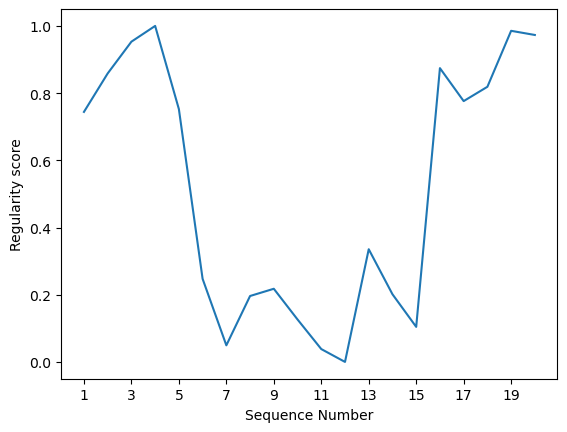

In [58]:
teacher1_regularity = plot_regularity(20, test_data, teacher1_predicted_sequences)
teacher1_mse = get_mse(test_data, teacher1_predicted_sequences)

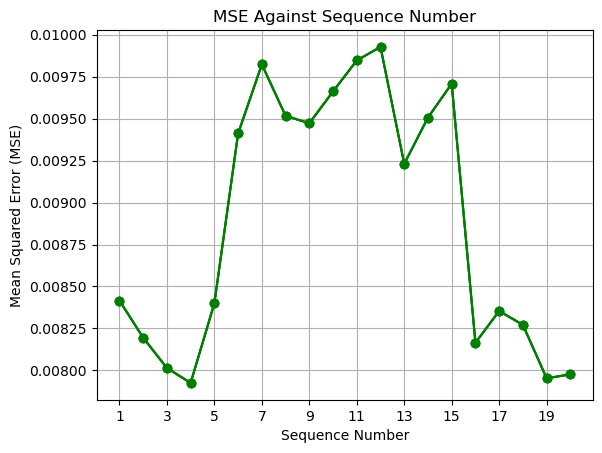

In [59]:
plot_mse_change(teacher1_mse)

### Teacher 2

In [60]:
teacher2_predicted_sequences = teacher2.predict(test_data)

1/1 [==============================] - 2s 2s/step


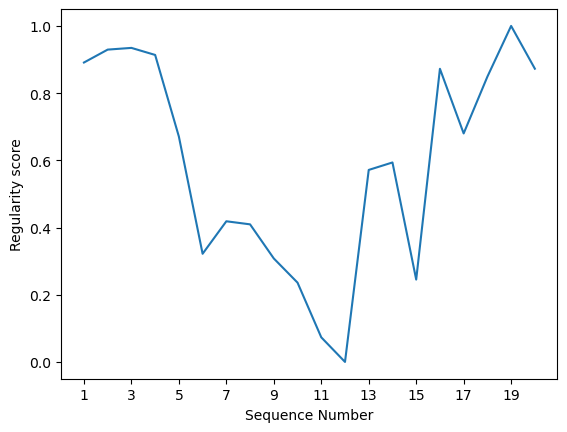

In [61]:
teacher2_regularity = plot_regularity(20, test_data, teacher2_predicted_sequences)
teacher2_mse = get_mse(test_data, teacher2_predicted_sequences)

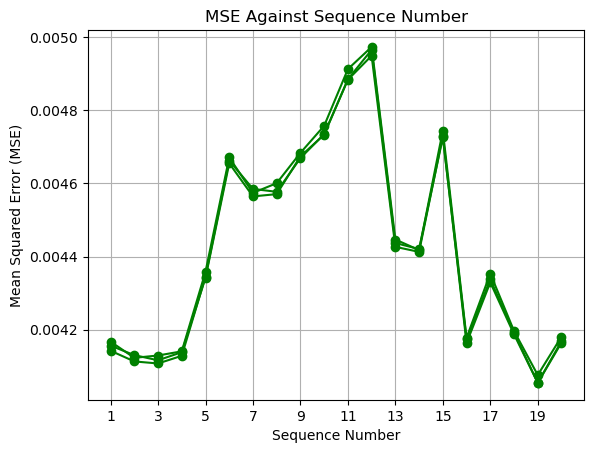

In [62]:
plot_mse_change(teacher2_mse)

## Student scores

### Student without kd scores

In [63]:
student1_predicted_sequences = student_model1.predict(test_data)

1/1 [==============================] - 2s 2s/step


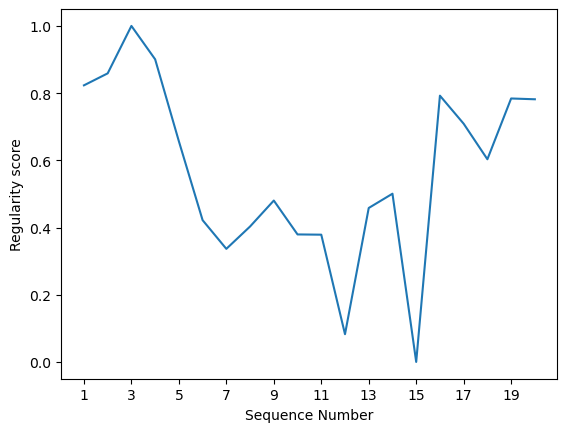

In [64]:
student1_regularity = plot_regularity(20, test_data, student1_predicted_sequences)
student1_mse = get_mse(test_data, student1_predicted_sequences)

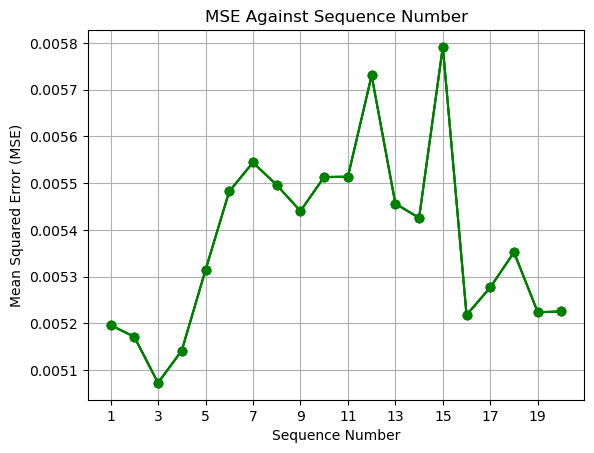

In [65]:
plot_mse_change(student1_mse)

### Student with kd scores

#### Single teacher 1

In [66]:
student_kd1_predicted_sequences = student_model_kd1.predict(test_data)

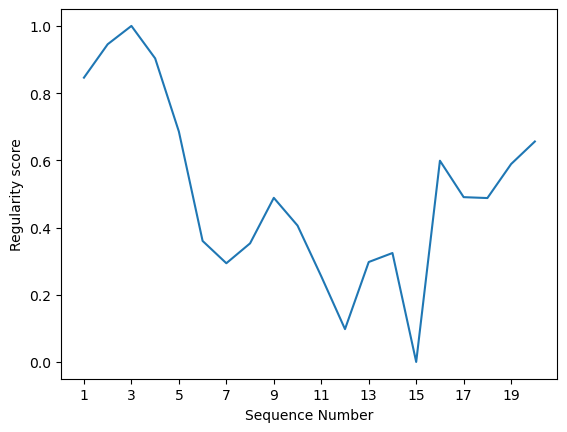

In [67]:
student_kd1_regularity = plot_regularity(20, test_data, student_kd1_predicted_sequences)
student_kd1_mse = get_mse(test_data, student_kd1_predicted_sequences)

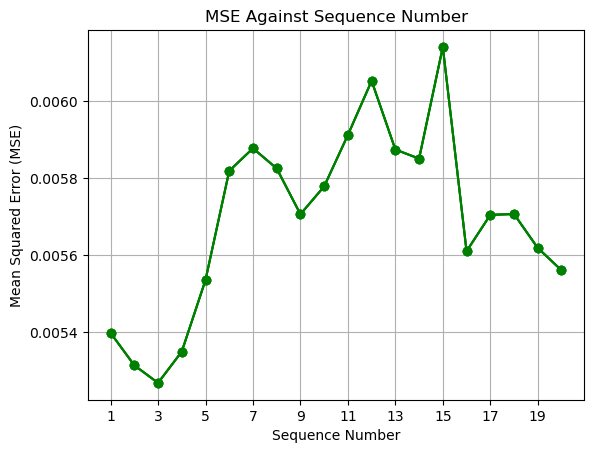

In [68]:
plot_mse_change(student_kd1_mse)

#### Single teacher 2

In [69]:
student_kd8_predicted_sequences = student_model_kd8.predict(test_data)

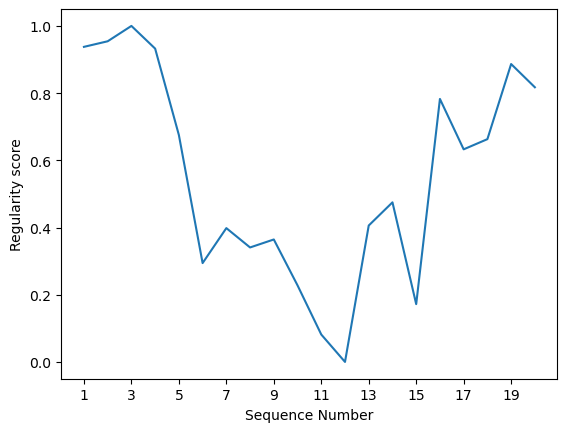

In [70]:
student_kd8_regularity = plot_regularity(20, test_data, student_kd8_predicted_sequences)
student_kd8_mse = get_mse(test_data, student_kd8_predicted_sequences)

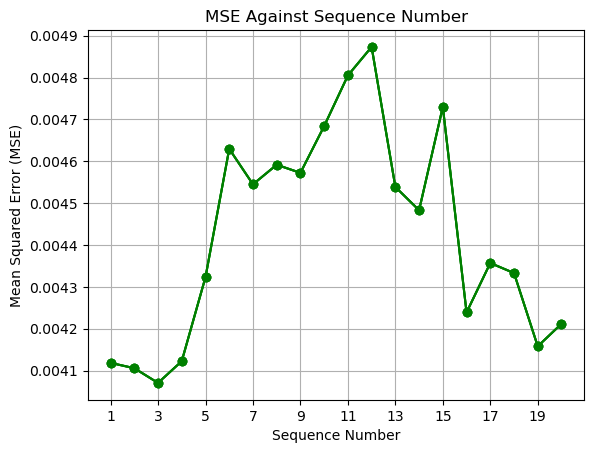

In [71]:
plot_mse_change(student_kd8_mse)

#### Two teachers

##### Two teachers 1

In [72]:
student_kd2_predicted_sequences = student_model_kd2.predict(test_data)

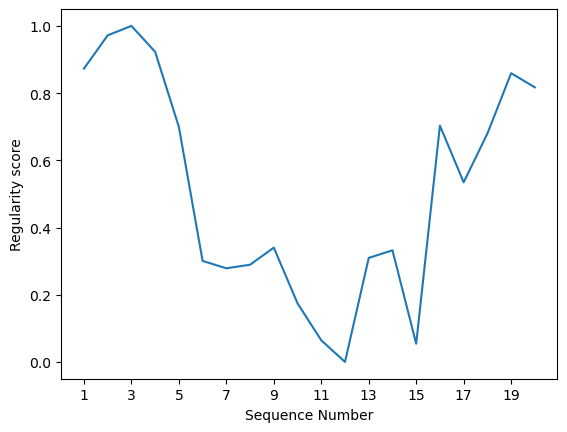

In [73]:
student_kd2_regularity = plot_regularity(20, test_data, student_kd2_predicted_sequences)
student_kd2_mse = get_mse(test_data, student_kd2_predicted_sequences)

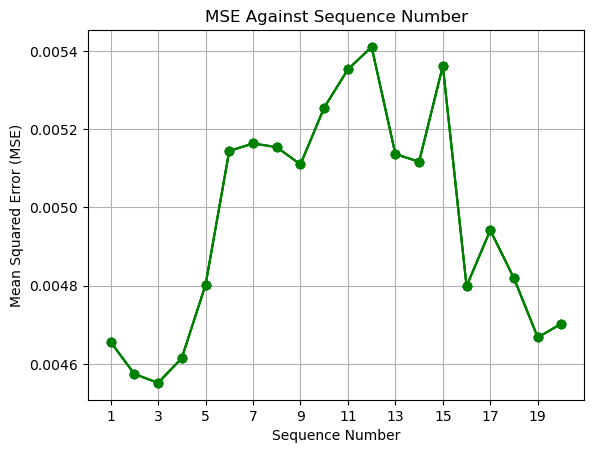

In [74]:
plot_mse_change(student_kd2_mse)

##### Two teachers 2

In [75]:
student_kd3_predicted_sequences = student_model_kd3.predict(test_data)

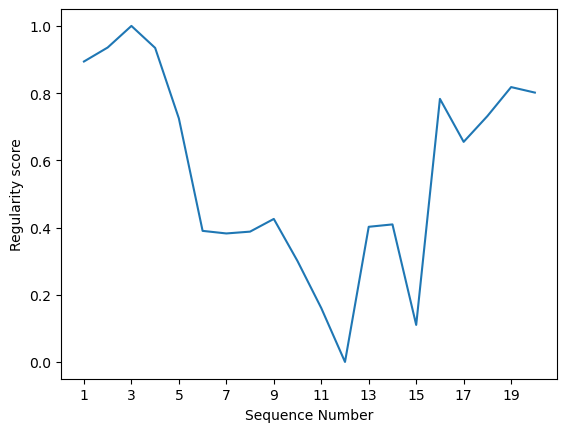

In [76]:
student_kd3_regularity = plot_regularity(20, test_data, student_kd3_predicted_sequences)
student_kd3_mse = get_mse(test_data, student_kd3_predicted_sequences)

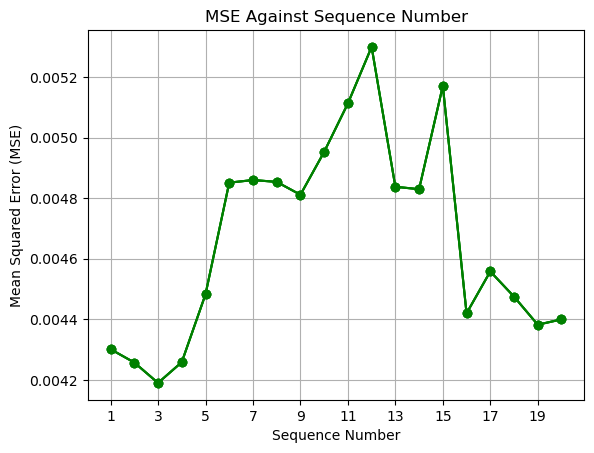

In [77]:
plot_mse_change(student_kd3_mse)

##### Two teachers 3

In [78]:
student_kd4_predicted_sequences = student_model_kd4.predict(test_data)

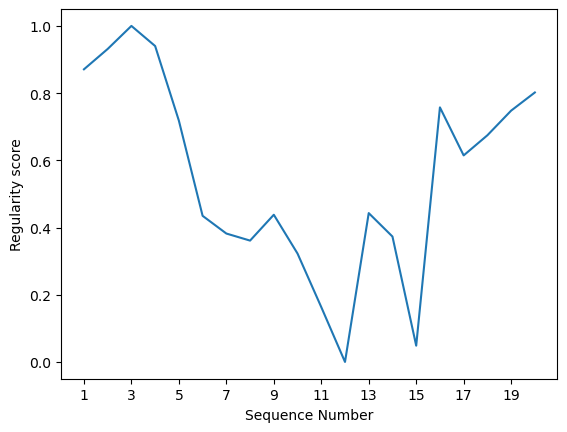

In [79]:
student_kd4_regularity = plot_regularity(20, test_data, student_kd4_predicted_sequences)
student_kd4_mse = get_mse(test_data, student_kd4_predicted_sequences)

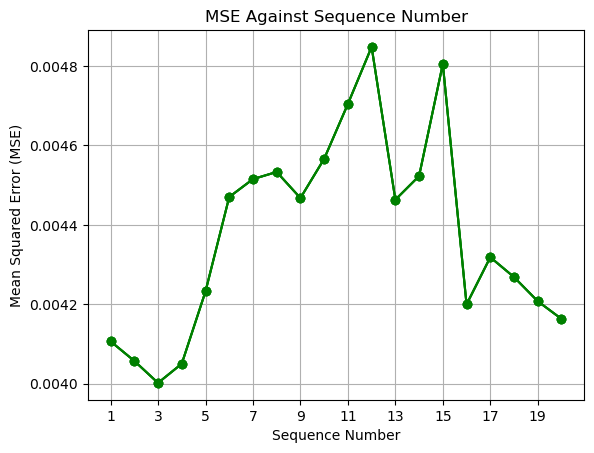

In [80]:
plot_mse_change(student_kd4_mse)

##### Two teachers 4

In [81]:
student_kd5_predicted_sequences = student_model_kd5.predict(test_data)

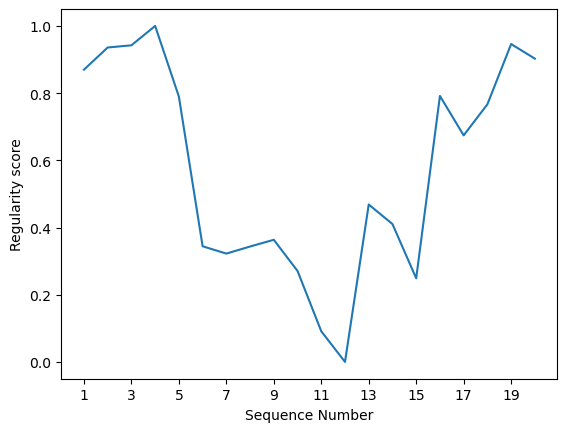

In [82]:
student_kd5_regularity = plot_regularity(20, test_data, student_kd5_predicted_sequences)
student_kd5_mse = get_mse(test_data, student_kd5_predicted_sequences)

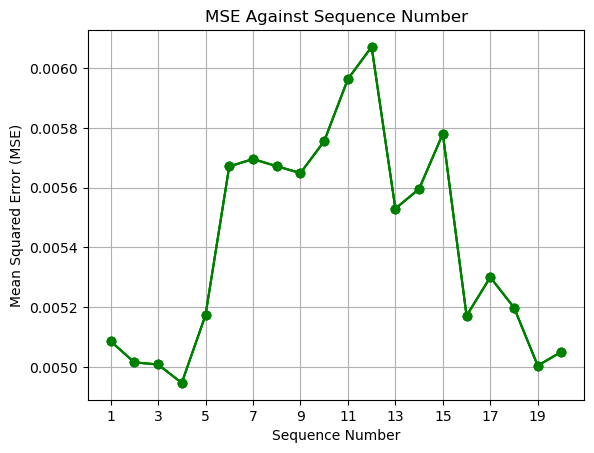

In [83]:
plot_mse_change(student_kd5_mse)

##### Two teachers 5 avg

In [84]:
student_kd6_predicted_sequences = student_model_kd6.predict(test_data)

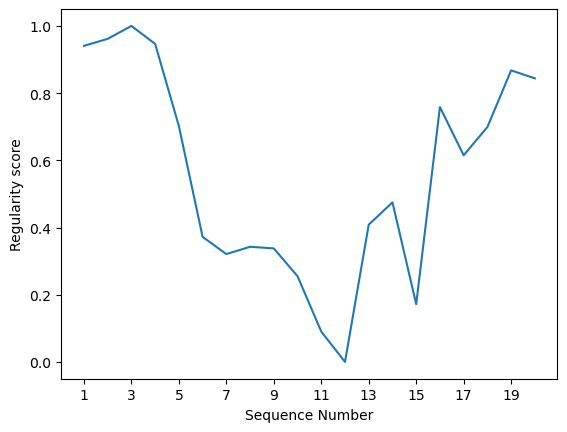

In [85]:
student_kd6_regularity = plot_regularity(20, test_data, student_kd6_predicted_sequences)
student_kd6_mse = get_mse(test_data, student_kd6_predicted_sequences)

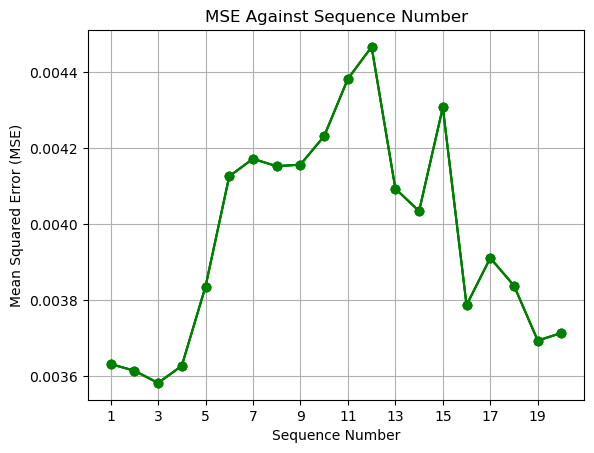

In [86]:
plot_mse_change(student_kd6_mse)

##### Two teachers 6 Dynamic weights

In [87]:
student_kd7_predicted_sequences = student_model_kd7.predict(test_data)

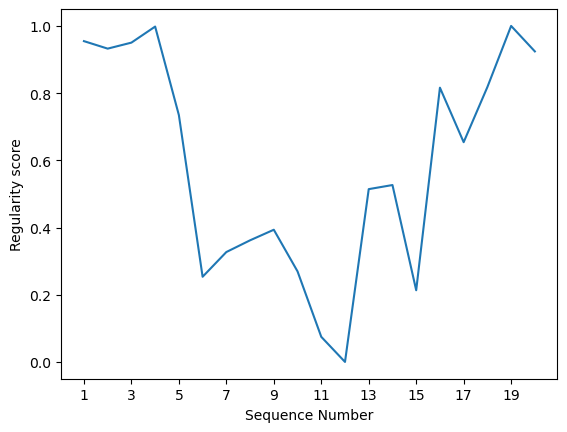

In [88]:
student_kd7_regularity = plot_regularity(20, test_data, student_kd7_predicted_sequences)
student_kd7_mse = get_mse(test_data, student_kd7_predicted_sequences)

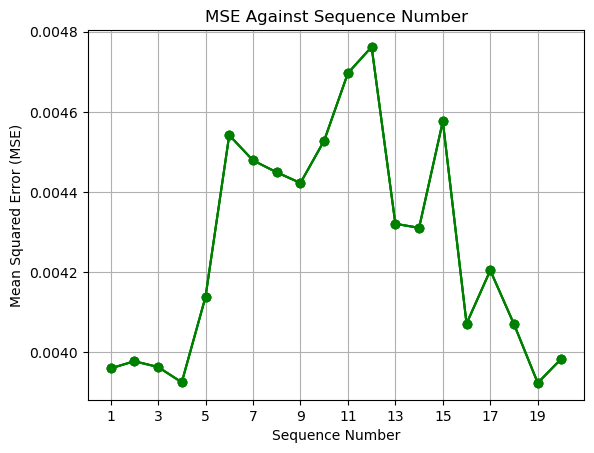

In [89]:
plot_mse_change(student_kd7_mse)

## Performance evaluation

In [90]:
print(teacher1_mse)

[[0.00841625 0.00841625 0.00841625]
 [0.00819484 0.00819484 0.00819484]
 [0.00801409 0.00801409 0.00801409]
 [0.00792538 0.00792538 0.00792538]
 [0.00839979 0.00839979 0.00839979]
 [0.00941131 0.00941131 0.00941131]
 [0.00982293 0.00982293 0.00982293]
 [0.00951674 0.00951674 0.00951674]
 [0.00947217 0.00947217 0.00947217]
 [0.0096618  0.0096618  0.0096618 ]
 [0.00984637 0.00984637 0.00984637]
 [0.00992709 0.00992709 0.00992709]
 [0.00923071 0.00923071 0.00923071]
 [0.009506   0.009506   0.009506  ]
 [0.0097078  0.0097078  0.0097078 ]
 [0.00816459 0.00816459 0.00816459]
 [0.00835374 0.00835374 0.00835374]
 [0.00827128 0.00827128 0.00827128]
 [0.00795298 0.00795298 0.00795298]
 [0.00797638 0.00797638 0.00797638]]


In [91]:
print(teacher2_mse)

[[0.0041672  0.00415613 0.00414214]
 [0.00412274 0.00413015 0.00411291]
 [0.00412914 0.00411609 0.00410731]
 [0.00414055 0.00413815 0.00412831]
 [0.00435815 0.00434196 0.00434497]
 [0.00467124 0.00465524 0.00466262]
 [0.00457417 0.00456462 0.00458517]
 [0.00460082 0.00457088 0.00457714]
 [0.00468384 0.00467426 0.00466952]
 [0.00475787 0.00473362 0.00473515]
 [0.00491305 0.00488531 0.00488405]
 [0.0049738  0.00496592 0.00494973]
 [0.00444665 0.00443705 0.00442661]
 [0.00441766 0.00442041 0.00441276]
 [0.00474459 0.00472595 0.0047306 ]
 [0.00417747 0.00417356 0.00416312]
 [0.0043535  0.00433746 0.0043294 ]
 [0.00419634 0.00419162 0.00418725]
 [0.00407562 0.00405433 0.00405408]
 [0.0041807  0.00416845 0.00416432]]


In [92]:
print(student1_mse)

[[0.0051964  0.0051964  0.0051964 ]
 [0.00517142 0.00517142 0.00517142]
 [0.00507278 0.00507278 0.00507278]
 [0.00514209 0.00514209 0.00514209]
 [0.00531414 0.00531414 0.00531414]
 [0.00548238 0.00548238 0.00548238]
 [0.00554422 0.00554422 0.00554422]
 [0.005496   0.005496   0.005496  ]
 [0.00544036 0.00544036 0.00544036]
 [0.00551314 0.00551314 0.00551314]
 [0.00551367 0.00551367 0.00551367]
 [0.00573031 0.00573031 0.00573031]
 [0.00545626 0.00545626 0.00545626]
 [0.00542569 0.00542569 0.00542569]
 [0.00579138 0.00579138 0.00579138]
 [0.00521801 0.00521801 0.00521801]
 [0.00527705 0.00527705 0.00527705]
 [0.00535223 0.00535223 0.00535223]
 [0.00522396 0.00522396 0.00522396]
 [0.00522557 0.00522557 0.00522557]]


In [93]:
print(student_kd1_mse)

[[0.00539818 0.00539818 0.00539818]
 [0.00531396 0.00531396 0.00531396]
 [0.00526811 0.00526811 0.00526811]
 [0.00534953 0.00534953 0.00534953]
 [0.00553565 0.00553565 0.00553565]
 [0.00581945 0.00581945 0.00581945]
 [0.00587825 0.00587825 0.00587825]
 [0.00582584 0.00582584 0.00582584]
 [0.00570673 0.00570673 0.00570673]
 [0.00577914 0.00577914 0.00577914]
 [0.00591286 0.00591286 0.00591286]
 [0.00605357 0.00605357 0.00605357]
 [0.00587496 0.00587496 0.00587496]
 [0.00585132 0.00585132 0.00585132]
 [0.0061418  0.0061418  0.0061418 ]
 [0.00561054 0.00561054 0.00561054]
 [0.00570504 0.00570504 0.00570504]
 [0.00570734 0.00570734 0.00570734]
 [0.00561907 0.00561907 0.00561907]
 [0.00556103 0.00556103 0.00556103]]


In [94]:
print(student_kd8_mse)

[[0.00411837 0.00411837 0.00411837]
 [0.0041056  0.0041056  0.0041056 ]
 [0.00407046 0.00407046 0.00407046]
 [0.00412245 0.00412245 0.00412245]
 [0.00432331 0.00432331 0.00432331]
 [0.00462973 0.00462973 0.00462973]
 [0.00454499 0.00454499 0.00454499]
 [0.00459178 0.00459178 0.00459178]
 [0.00457242 0.00457242 0.00457242]
 [0.00468412 0.00468412 0.00468412]
 [0.00480517 0.00480517 0.00480517]
 [0.00487334 0.00487334 0.00487334]
 [0.00453874 0.00453874 0.00453874]
 [0.00448301 0.00448301 0.00448301]
 [0.0047302  0.0047302  0.0047302 ]
 [0.00423884 0.00423884 0.00423884]
 [0.00435699 0.00435699 0.00435699]
 [0.00433299 0.00433299 0.00433299]
 [0.00415793 0.00415793 0.00415793]
 [0.00421171 0.00421171 0.00421171]]


In [95]:
print(student_kd2_mse)

[[0.00465613 0.00465613 0.00465613]
 [0.00457406 0.00457406 0.00457406]
 [0.00455106 0.00455106 0.00455106]
 [0.00461461 0.00461461 0.00461461]
 [0.00480166 0.00480166 0.00480166]
 [0.0051445  0.0051445  0.0051445 ]
 [0.00516369 0.00516369 0.00516369]
 [0.00515436 0.00515436 0.00515436]
 [0.00510996 0.00510996 0.00510996]
 [0.00525547 0.00525547 0.00525547]
 [0.00535312 0.00535312 0.00535312]
 [0.00541072 0.00541072 0.00541072]
 [0.00513676 0.00513676 0.00513676]
 [0.00511691 0.00511691 0.00511691]
 [0.00536225 0.00536225 0.00536225]
 [0.00479844 0.00479844 0.00479844]
 [0.00494183 0.00494183 0.00494183]
 [0.00481844 0.00481844 0.00481844]
 [0.00466752 0.00466752 0.00466752]
 [0.00470267 0.00470267 0.00470267]]


In [96]:
print(student_kd3_mse)

[[0.00430151 0.00430151 0.00430151]
 [0.00425758 0.00425758 0.00425758]
 [0.00419025 0.00419025 0.00419025]
 [0.00425874 0.00425874 0.00425874]
 [0.00448259 0.00448259 0.00448259]
 [0.00485112 0.00485112 0.00485112]
 [0.00485977 0.00485977 0.00485977]
 [0.00485368 0.00485368 0.00485368]
 [0.00481126 0.00481126 0.00481126]
 [0.00495268 0.00495268 0.00495268]
 [0.00511261 0.00511261 0.00511261]
 [0.00529907 0.00529907 0.00529907]
 [0.00483752 0.00483752 0.00483752]
 [0.00482959 0.00482959 0.00482959]
 [0.00517049 0.00517049 0.00517049]
 [0.00441988 0.00441988 0.00441988]
 [0.00455815 0.00455815 0.00455815]
 [0.00447504 0.00447504 0.00447504]
 [0.00438234 0.00438234 0.00438234]
 [0.00439994 0.00439994 0.00439994]]


In [97]:
print(student_kd4_mse)

[[0.00410682 0.00410682 0.00410682]
 [0.00405753 0.00405753 0.00405753]
 [0.00400216 0.00400216 0.00400216]
 [0.00405044 0.00405044 0.00405044]
 [0.00423235 0.00423235 0.00423235]
 [0.00447006 0.00447006 0.00447006]
 [0.00451502 0.00451502 0.00451502]
 [0.004533   0.004533   0.004533  ]
 [0.00446733 0.00446733 0.00446733]
 [0.00456608 0.00456608 0.00456608]
 [0.00470414 0.00470414 0.00470414]
 [0.00484763 0.00484763 0.00484763]
 [0.00446316 0.00446316 0.00446316]
 [0.00452273 0.00452273 0.00452273]
 [0.00480484 0.00480484 0.00480484]
 [0.0041997  0.0041997  0.0041997 ]
 [0.00431846 0.00431846 0.00431846]
 [0.00426846 0.00426846 0.00426846]
 [0.00420773 0.00420773 0.00420773]
 [0.00416319 0.00416319 0.00416319]]


In [98]:
print(student_kd5_mse)

[[0.00508656 0.00508656 0.00508656]
 [0.00501537 0.00501537 0.00501537]
 [0.00500836 0.00500836 0.00500836]
 [0.00494666 0.00494666 0.00494666]
 [0.00517351 0.00517351 0.00517351]
 [0.00567086 0.00567086 0.00567086]
 [0.00569578 0.00569578 0.00569578]
 [0.00567169 0.00567169 0.00567169]
 [0.00564883 0.00564883 0.00564883]
 [0.00575516 0.00575516 0.00575516]
 [0.00596354 0.00596354 0.00596354]
 [0.00607086 0.00607086 0.00607086]
 [0.00552981 0.00552981 0.00552981]
 [0.00559562 0.00559562 0.00559562]
 [0.00578029 0.00578029 0.00578029]
 [0.00517147 0.00517147 0.00517147]
 [0.0053002  0.0053002  0.0053002 ]
 [0.00519871 0.00519871 0.00519871]
 [0.00500439 0.00500439 0.00500439]
 [0.00505105 0.00505105 0.00505105]]


In [99]:
print(student_kd6_mse)

[[0.00363192 0.00363192 0.00363192]
 [0.00361428 0.00361428 0.00361428]
 [0.00358218 0.00358218 0.00358218]
 [0.0036269  0.0036269  0.0036269 ]
 [0.00383542 0.00383542 0.00383542]
 [0.00412529 0.00412529 0.00412529]
 [0.00417131 0.00417131 0.00417131]
 [0.00415187 0.00415187 0.00415187]
 [0.00415607 0.00415607 0.00415607]
 [0.00423088 0.00423088 0.00423088]
 [0.00438164 0.00438164 0.00438164]
 [0.00446541 0.00446541 0.00446541]
 [0.0040928  0.0040928  0.0040928 ]
 [0.00403379 0.00403379 0.00403379]
 [0.00430652 0.00430652 0.00430652]
 [0.00378662 0.00378662 0.00378662]
 [0.00391064 0.00391064 0.00391064]
 [0.00383774 0.00383774 0.00383774]
 [0.00369341 0.00369341 0.00369341]
 [0.0037136  0.0037136  0.0037136 ]]


In [100]:
print(student_kd7_mse)

[[0.00395994 0.00395994 0.00395994]
 [0.00397784 0.00397784 0.00397784]
 [0.00396347 0.00396347 0.00396347]
 [0.00392526 0.00392526 0.00392526]
 [0.00413828 0.00413828 0.00413828]
 [0.00454188 0.00454188 0.00454188]
 [0.00447898 0.00447898 0.00447898]
 [0.00444925 0.00444925 0.00444925]
 [0.00442255 0.00442255 0.00442255]
 [0.00452819 0.00452819 0.00452819]
 [0.00469666 0.00469666 0.00469666]
 [0.00476207 0.00476207 0.00476207]
 [0.00432078 0.00432078 0.00432078]
 [0.00431063 0.00431063 0.00431063]
 [0.00457641 0.00457641 0.00457641]
 [0.00407172 0.00407172 0.00407172]
 [0.00420465 0.00420465 0.00420465]
 [0.00407019 0.00407019 0.00407019]
 [0.00392372 0.00392372 0.00392372]
 [0.0039845  0.0039845  0.0039845 ]]


In [101]:
all_models_mse = {
    "teacher1": teacher1_mse,
    "teacher2": teacher2_mse,
    "student1": student1_mse,
    "studentkd1": student_kd1_mse,
    "studentkd2": student_kd2_mse,
    "studentkd3": student_kd3_mse,
    "studentkd4": student_kd4_mse,
    "studentkd5": student_kd5_mse,
    "studentkd6": student_kd6_mse,
    "studentkd7": student_kd7_mse
}

In [102]:
print(teacher1_regularity)

[0.74409544 0.85858834 0.9531161  1.         0.7524755  0.24722606
 0.04938531 0.19619775 0.21772593 0.12630469 0.03826278 0.
 0.3353756  0.20138514 0.10431802 0.8743578  0.7762672  0.81885487
 0.98544073 0.97305363]


In [103]:
print(teacher2_regularity)

[0.8910812  0.9295018  0.93461084 0.91362244 0.67066693 0.32186413
 0.41858375 0.40944636 0.3078856  0.23594153 0.07318026 0.
 0.5714183  0.5936259  0.24514288 0.8724154  0.6799954  0.8489886
 1.         0.87267447]


In [104]:
print(student1_regularity)

[0.82317686 0.85880315 1.         0.9006327  0.65667975 0.4218648
 0.336537   0.40308005 0.4802994  0.37944406 0.3786956  0.08251345
 0.45815486 0.5006403  0.         0.7924241  0.70896137 0.6031443
 0.78405464 0.7816842 ]


In [105]:
print(student_kd1_regularity)

[0.8460401  0.9454563  1.         0.9034396  0.68558645 0.3600908
 0.2936933  0.3528676  0.4883417  0.4058423  0.25471473 0.09763956
 0.29735756 0.32413447 0.         0.5988268  0.49038064 0.48772693
 0.5889536  0.65604305]


In [106]:
print(student_kd8_regularity)

[0.93770486 0.9543065  1.         0.9324788  0.6752509  0.29413527
 0.39823788 0.34068078 0.36443698 0.22782189 0.08156234 0.
 0.4059502  0.47493726 0.17195427 0.7826818  0.63269556 0.6630106
 0.8865662  0.8174307 ]


In [107]:
print(student_kd2_regularity)

[0.87295145 0.9720279  1.         0.92297703 0.6993735  0.3005774
 0.27866137 0.28927755 0.34014034 0.17430091 0.06435388 0.
 0.3094718  0.33218312 0.05413318 0.70322585 0.53464806 0.67956126
 0.85923094 0.81722414]


In [108]:
print(student_kd3_regularity)

[0.8940949  0.9357599  1.         0.9345851  0.72460896 0.3900286
 0.38235152 0.38778156 0.4255739  0.30006075 0.16029125 0.
 0.40218365 0.40925813 0.11022985 0.7829062  0.65494215 0.7316599
 0.8179845  0.8015729 ]


In [109]:
print(student_kd4_regularity)

[0.870871   0.93144965 1.         0.94016707 0.7180314  0.4348057
 0.38212603 0.36107063 0.4380476  0.3224932  0.1631664  0.
 0.4429407  0.37311363 0.04845011 0.7575666  0.61461926 0.6745677
 0.74786747 0.80193675]


In [110]:
print(student_kd5_regularity)

[0.8698042  0.93577355 0.94230175 1.         0.78974736 0.3442285
 0.32241237 0.34346646 0.36348802 0.27068764 0.0911938  0.
 0.46852684 0.4103306  0.24890089 0.79156196 0.6742941  0.7666583
 0.94602865 0.90264034]


In [111]:
print(student_kd6_regularity)

[0.9406072  0.9615898  1.         0.94658047 0.70170146 0.37219816
 0.32094324 0.34263366 0.33787292 0.25500667 0.09029639 0.
 0.40855378 0.4748813  0.17207724 0.75844437 0.6150764  0.69905466
 0.86771023 0.8439395 ]


In [112]:
print(student_kd7_regularity)

[0.9547207  0.93241334 0.95028263 0.9980561  0.73458284 0.25341892
 0.32704055 0.3619331  0.39340532 0.2694553  0.07467437 0.
 0.5142528  0.52644587 0.21332693 0.81620306 0.65397775 0.81813926
 1.         0.9241593 ]


In [113]:
def compare_regularity(regularity_scores, legend, threshold=0.6, doPlotThreshold=False):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Define a list of colors
    #colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'olive', 'teal', 'navy']
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3', 'b', '#bebada', '#fb8072', '#80b1d3']


    # Plot each line with a unique color
    for i, scores in enumerate(regularity_scores):
        frame_numbers = [x+1 for x in range(len(scores))]
        plt.plot(frame_numbers, scores, color=colors[i % len(colors)])

    # Add labels and title
    plt.xlabel('Sequence number')
    plt.ylabel('Regularity')
    plt.title('Regularity comparison')
    
    sequence_numbers = [i for i in range(1, len(regularity_scores[0]) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    
    # Add threshold line if required
    if doPlotThreshold:
        plt.axhline(y=threshold, color='black', linestyle='--')

    # Add legend
    plt.legend(legend, loc='lower left', bbox_to_anchor=(1.02, 0))
#     plt.legend(legend, loc='lower left')

    # Show plot
    plt.show()

In [114]:
# compare_regularity([teacher1_regularity, teacher2_regularity, student1_regularity, student_kd1_regularity, student_kd2_regularity, student_kd3_regularity, student_kd4_regularity, student_kd5_regularity, student_kd6_regularity, student_kd7_regularity], ["Teacher 1", "Teacher 2", "Student", "StudentKD1", "StudentKD2", "StudentKD3", "StudentKD4", "StudentKD5", "StudentKD6 AVG", "StudentKD7 DYNAMIC"])
# compare_mse([teacher1_mse-mean, teacher2_mse-mean, student_kd7_mse-mean], ["Teacher 1", "Teacher 2", "StudentKD7 DYNAMIC"], min=0, max=0, doPlotThreshold=False)

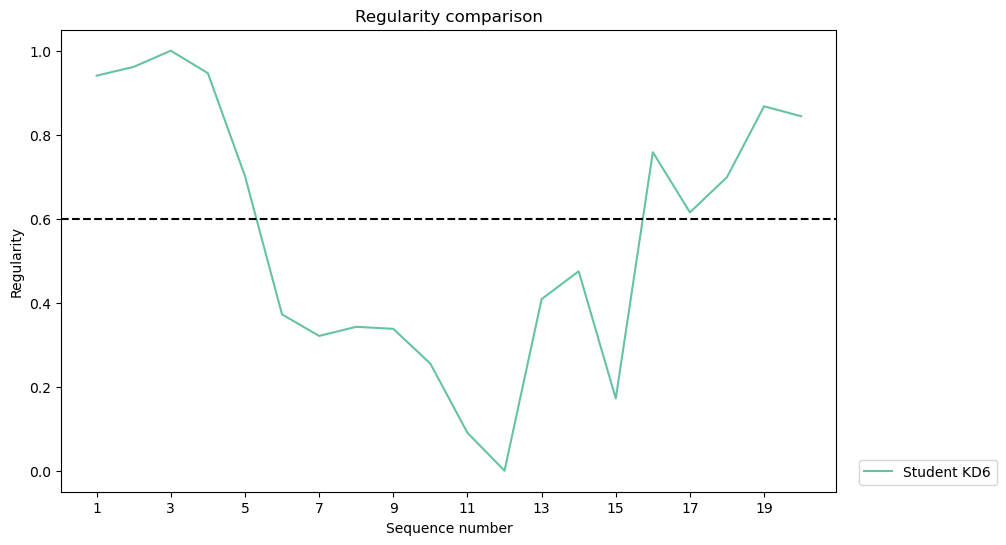

In [115]:
compare_regularity([student_kd6_regularity], ["Student KD6"], doPlotThreshold=True)

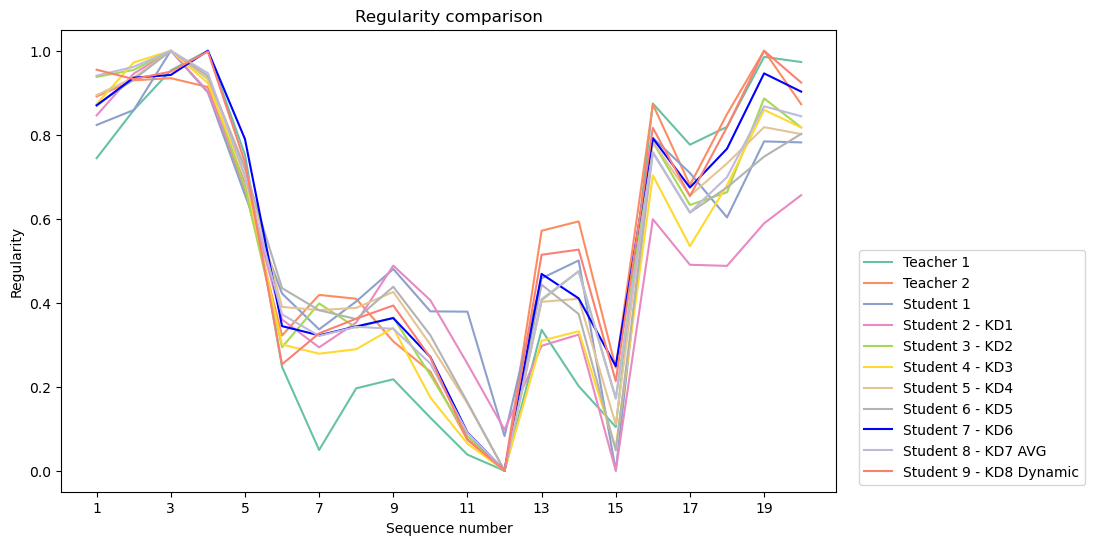

In [116]:
regularity_temp = [teacher1_regularity, teacher2_regularity, student1_regularity, student_kd1_regularity, student_kd8_regularity, student_kd2_regularity, student_kd3_regularity, student_kd4_regularity, student_kd5_regularity, student_kd6_regularity, student_kd7_regularity]
names_temp = ["Teacher 1", "Teacher 2", "Student 1", "Student 2 - KD1", "Student 3 - KD2", "Student 4 - KD3", "Student 5 - KD4", "Student 6 - KD5", "Student 7 - KD6", "Student 8 - KD7 AVG", "Student 9 - KD8 Dynamic"]
compare_regularity(regularity_temp, names_temp, doPlotThreshold=False)

In [117]:
def compare_mse(mse_scores, legend, min, max, doPlotThreshold=False):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot each line
    for scores in mse_scores:
        frame_numbers = [x+1 for x in range(len(scores))]
        plt.plot(frame_numbers, scores)

    # Add labels and title
    plt.xlabel('Sequence')
    plt.ylabel('MSE')
    plt.title('MSE comparision')

    if doPlotThreshold:
        plt.axhline(y=min, color='black', linestyle='--')
        plt.axhline(y=max, color='black', linestyle='--')

    plt.legend(legend)

    # Show plot
    plt.show()

In [118]:
# plot_mse_change(teacher1_mse, mean_mse=mean_mse_values["teacher1"], legend=["Teacher 1"], doPlotThreshold=True)
# plot_mse_change(teacher2_mse, mean_mse=mean_mse_values["teacher2"], legend=["Teacher 2"], doPlotThreshold=True)
# plot_mse_change(student1_mse, mean_mse=mean_mse_values["student1"], legend=["Student 1"], doPlotThreshold=True)
# plot_mse_change(student_kd1_mse, mean_mse=mean_mse_values["studentkd1"], legend=["Student KD1"], doPlotThreshold=True)
# plot_mse_change(student_kd2_mse, mean_mse=mean_mse_values["studentkd2"], legend=["Student KD2"], doPlotThreshold=True)
# plot_mse_change(student_kd3_mse, mean_mse=mean_mse_values["studentkd3"], legend=["Student KD3"], doPlotThreshold=True)
# plot_mse_change(student_kd4_mse, mean_mse=mean_mse_values["studentkd4"], legend=["Student KD4"], doPlotThreshold=True)
# plot_mse_change(student_kd5_mse, mean_mse=mean_mse_values["studentkd5"], legend=["Student KD5"], doPlotThreshold=True)
# plot_mse_change(student_kd6_mse, mean_mse=mean_mse_values["studentkd6"], legend=["Student KD6"], doPlotThreshold=True)
# plot_mse_change(student_kd7_mse, mean_mse=mean_mse_values["studentkd7"], legend=["Student KD7"], doPlotThreshold=True)


In [119]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_metrics(pred_val, threshold, groundtruth):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    metrics = {}
    
    
    for i in range(len(groundtruth)):
        pred = pred_val[i]
        truth = groundtruth[i]
        
        if pred < threshold:  # Anomaly detected
            if truth == 1:  # True positive
                tp += 1
            else:  # False positive
                fp += 1
        else:  # No anomaly detected
            if truth == 0:  # True negative
                tn += 1
            else:  # False negative
                fn += 1
    
    metrics["confusion_matrix"] = tp, fp, tn, fn
    
    metrics["tpr"] = tp / (tp + fn)
    metrics["fpr"] = fp / (fp + tn)
    
    metrics['precision'] = tp / (tp + fp)
    metrics['specificity'] = tn / (tn + fp)
    
    
    #EER
    far = fp / (fp + tn)
    frr = fn / (fn + tp)
    metrics['eer'] = ((far + frr) / 2) * 100
    
    metrics["accuracy"] = ((tp + tn) / (tp + tn + fp + fn)) * 100
    
    # Calculate ROC curve and AUC
    inverse_pred = 1 - pred_val
    fpr, tpr, thresholds = roc_curve(groundtruth, inverse_pred)
    #metrics["roc_curve"] = (fpr, tpr)
    metrics["auc"] = roc_auc_score(groundtruth, inverse_pred)
    
    return metrics

In [120]:
ground_truth_test_001 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
ground_truth_test_003 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ground_truth_test_013 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
ground_truth_test_006 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ground_truth_test_032 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


all_ground_truths = []
all_ground_truths.extend(ground_truth_test_001)
all_ground_truths.extend(ground_truth_test_003)
all_ground_truths.extend(ground_truth_test_013)
all_ground_truths.extend(ground_truth_test_006)
all_ground_truths.extend(ground_truth_test_032)

print(len(all_ground_truths))

100


In [121]:
def get_predicted_mse(model, test_data):
    model_predicted_sequences = model.predict(test_data)
    model_mse = get_mse(test_data, model_predicted_sequences)
    return model_mse

In [122]:
def get_predicted_regularity(model, sequences):
    reconstructed_sequences = model.predict(sequences)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,len(sequences))])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost) - np.min(sequences_reconstruction_cost))
    sr = 1.0 - sa
    # ( mse - min_mse ) / max_mse - min_mse
    return sr

In [123]:
test_data1 = preprocess_test_dataset(test_path1)
test_data2 = preprocess_test_dataset(test_path2)
test_data3 = preprocess_test_dataset(test_path3)
test_data4 = preprocess_test_dataset(test_path4)
test_data5 = preprocess_test_dataset(test_path5)

In [124]:
import pickle

all_metrics = {}

threshold = 0.6
    
if not all_metrics:
    for modelname in all_models.keys():
        #both all_model_mse and mean_mse_values have the same keys
        print(modelname)
        model_reg1 = get_predicted_regularity(all_models[modelname], test_data1)
        model_reg2 = get_predicted_regularity(all_models[modelname], test_data2)
        model_reg3 = get_predicted_regularity(all_models[modelname], test_data3)
        model_reg4 = get_predicted_regularity(all_models[modelname], test_data4)
        model_reg5 = get_predicted_regularity(all_models[modelname], test_data5)
        
        concatenated_mse = np.concatenate((model_reg1, model_reg2, model_reg3, model_reg4, model_reg5))
        all_metrics[modelname] = calculate_metrics(concatenated_mse, threshold, all_ground_truths)
        print(all_metrics[modelname], "\n\n")
    

teacher1
1/1 [==============================] - 0s 62ms/step
{'confusion_matrix': (60, 0, 33, 7), 'tpr': 0.8955223880597015, 'fpr': 0.0, 'precision': 1.0, 'specificity': 1.0, 'eer': 5.223880597014925, 'accuracy': 93.0, 'auc': 0.973767526006332} 


teacher2
1/1 [==============================] - 0s 28ms/step
{'confusion_matrix': (57, 2, 31, 10), 'tpr': 0.8507462686567164, 'fpr': 0.06060606060606061, 'precision': 0.9661016949152542, 'specificity': 0.9393939393939394, 'eer': 10.49298959746721, 'accuracy': 88.0, 'auc': 0.9556761646313885} 


student1
1/1 [==============================] - 0s 32ms/step
{'confusion_matrix': (54, 2, 31, 13), 'tpr': 0.8059701492537313, 'fpr': 0.06060606060606061, 'precision': 0.9642857142857143, 'specificity': 0.9393939393939394, 'eer': 12.731795567616464, 'accuracy': 85.0, 'auc': 0.9380370872908186} 


studentkd1
{'confusion_matrix': (59, 4, 29, 8), 'tpr': 0.8805970149253731, 'fpr': 0.12121212121212122, 'precision': 0.9365079365079365, 'specificity': 0.878787

In [125]:
import pandas as pd
df = pd.DataFrame.from_dict(all_metrics)
df = df.transpose()
df

,confusion_matrix,tpr,fpr,precision,specificity,eer,accuracy,auc
teacher1,"(60, 0, 33, 7)",0.895522,0.0,1.0,1.0,5.223881,93.0,0.973768
teacher2,"(57, 2, 31, 10)",0.850746,0.060606,0.966102,0.939394,10.49299,88.0,0.955676
student1,"(54, 2, 31, 13)",0.80597,0.060606,0.964286,0.939394,12.731796,85.0,0.938037
studentkd1,"(59, 4, 29, 8)",0.880597,0.121212,0.936508,0.878788,12.030755,88.0,0.933967
studentkd2,"(59, 1, 32, 8)",0.880597,0.030303,0.983333,0.969697,7.485301,91.0,0.963817
studentkd3,"(60, 0, 33, 7)",0.895522,0.0,1.0,1.0,5.223881,93.0,0.972863
studentkd4,"(61, 2, 31, 6)",0.910448,0.060606,0.968254,0.939394,7.507915,92.0,0.973768
studentkd5,"(61, 1, 32, 6)",0.910448,0.030303,0.983871,0.969697,5.992763,93.0,0.96834
studentkd6,"(59, 0, 33, 8)",0.880597,0.0,1.0,1.0,5.970149,92.0,0.970602
studentkd7,"(60, 1, 32, 7)",0.895522,0.030303,0.983607,0.969697,6.739032,92.0,0.966531


In [126]:
# df.to_csv(MODEL_METRICS_TABULATED_PATH)